In [1]:
import numpy as np
import torch
import ot
import matplotlib.pylab as pl
import ot.plot
import time

In [2]:
import sys
sys.path.append('../code/')
from generate_data import make_data

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [4]:
n,d=50,50
np.random.seed(0)
X,_=make_data('iso_gaussians',n,d)
Y,_=make_data('iso_gaussians',n-1,d)
y2=torch.zeros((1,d))
y2[:,0]=-7
Y=torch.concatenate((Y,y2),axis=0)
C=ot.dist(X,Y)

In [5]:
y2

tensor([[-7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
a=torch.ones((n,))
b=torch.ones((n,))
#b=torch.randint(1, 5, (n,),dtype=float)
#b/=torch.sum(b)
#b=b.float()

(-10.0, 10.0)

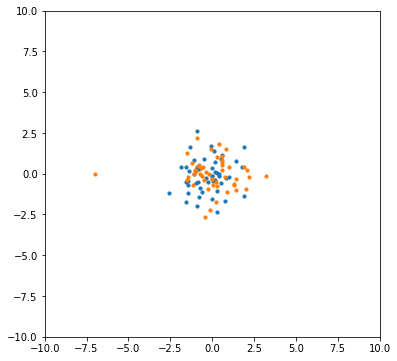

In [7]:
s=10
pl.figure(figsize=(6,6))
pl.scatter(X[:, 0], X[:, 1], c='C0',s=s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=s)
pl.xlim(-10,10)
pl.ylim(-10,10)

In [17]:
import cvxpy as cp
def UOT_W(a,b,C,lam,lam2=None,Cx=None,Cy=None,innerplan=False,solver="ECOS"):
    if lam2 is None:
        lam2=lam

    n,m=C.shape
    
        
    pi = cp.Variable((n,m))
    Qx=cp.Variable((n,n))
    Qy=cp.Variable((m,m))

    ### penalization Wasserstein ###
    objective = cp.Minimize(cp.sum(cp.multiply(pi,C))
                +lam*cp.sum(cp.multiply(Qx,Cx))
                +lam2*cp.sum(cp.multiply(Qy,Cy)))
    constraints = [pi>=0,Qx>=0,Qy>=0,
                   Qx@torch.ones(n)==pi@torch.ones(m),
                   Qy@torch.ones(m)==(pi.T)@torch.ones(n),
                   Qx.T@torch.ones(n)==a,
                   Qy.T@torch.ones(m)==b]

    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=solver,verbose=True,abstol=1e-3)
    if innerplan:
        return pi.value,Qx.value,Qy.value
    else:
        return pi.value

In [18]:
C=ot.dist(X,Y)
Cx=ot.dist(X,X)
Cy=ot.dist(Y,Y)

start = time.time()
P,Qx,Qy=UOT_W(a,b,C,lam=.1,Cx=Cx,Cy=Cy,innerplan=True,solver="ECOS")
print(time.time()-start)
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 29 03:00:35 PM: Your problem has 7500 variables, 7 constraints, and 0 parameters.
(CVXPY) Jan 29 03:00:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 29 03:00:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 29 03:00:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 29 03:00:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 29 03:00:35 PM: Compiling problem (target solver=ECOS).
(C

/home/gui/.local/lib/python3.10/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(-10.0, 10.0)

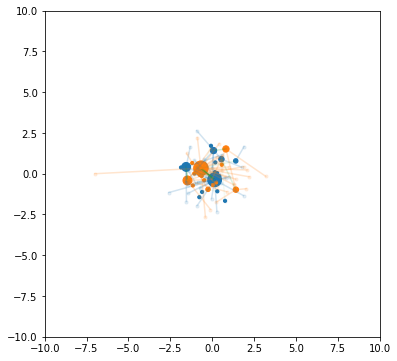

In [10]:
s=10
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X, Y, P, c='C2')
ot.plot.plot2D_samples_mat(X, X, Qx, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(Y, Y, Qy, c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], c='C0',s=a_W*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b_W*s)
pl.scatter(X[:, 0], X[:, 1], c='C0',label="$\mu_1$",s=s,alpha=.1)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',label="$\mu_2$",s=s,alpha=.1)
pl.xlim(-10,10)
pl.ylim(-10,10)

In [11]:
n,d=50,2
np.random.seed(0)
X,_=make_data('iso_gaussians',n,d)
Y,_=make_data('iso_gaussians',n-1,d)
Y=torch.concatenate((Y,torch.tensor([[-5,0]])),axis=0)
Y=Y+torch.tensor([10,0])
C=ot.dist(X,Y)

(-15.0, 15.0)

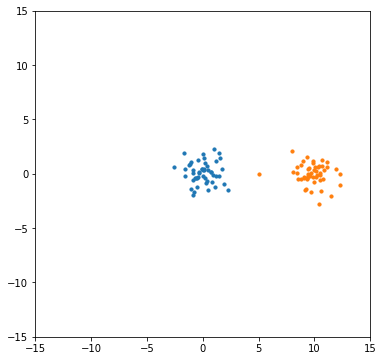

In [12]:
s=10
pl.figure(figsize=(6,6))
pl.scatter(X[:, 0], X[:, 1], c='C0',s=s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=s)
pl.xlim(-15,15)
pl.ylim(-15,15)

In [13]:
C=ot.dist(X,Y)
Cx=ot.dist(X,X)
Cy=ot.dist(Y,Y)

start = time.time()
P,Qx,Qy=UOT_W(a,b,C,lam=1,Cx=Cx,Cy=Cy,innerplan=True,solver="CLARABEL")
print(time.time()-start)
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)

0.14048218727111816


(-15.0, 15.0)

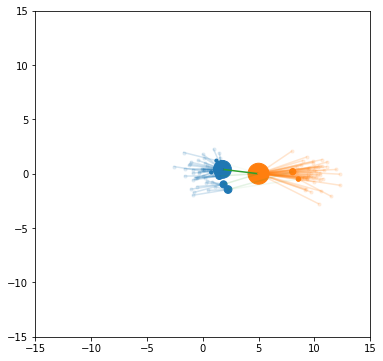

In [14]:
s=10
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X, Y, P, c='C2')
ot.plot.plot2D_samples_mat(X, X, Qx, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(Y, Y, Qy, c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], c='C0',s=a_W*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b_W*s)
pl.scatter(X[:, 0], X[:, 1], c='C0',label="$\mu_1$",s=s,alpha=.1)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',label="$\mu_2$",s=s,alpha=.1)
pl.xlim(-15,15)
pl.ylim(-15,15)